In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import cv2
from imblearn.over_sampling import RandomOverSampler

C:\Users\KIT\AppData\Local\Temp\ipykernel_14712\2636861248.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Загрузка и предварительная обработка данных
data = pd.read_csv('severstal-steel-defect-detection\\train.csv')

In [3]:
# Основная информация о данных
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7095 entries, 0 to 7094
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        7095 non-null   object
 1   ClassId        7095 non-null   int64 
 2   EncodedPixels  7095 non-null   object
dtypes: int64(1), object(2)
memory usage: 166.4+ KB
None


In [4]:
# Первые несколько строк
print(data.head())

         ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...
2  000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...
3  000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...
4  0014fce06.jpg        3  229501 11 229741 33 229981 55 230221 77 230468...


In [5]:
# Проверка на пропущенные значения
print(data.isnull().sum())

ImageId          0
ClassId          0
EncodedPixels    0
dtype: int64


In [6]:
# Распределение классов дефектов
class_distribution = data['ClassId'].value_counts()
print(class_distribution)

ClassId
3    5150
1     897
4     801
2     247
Name: count, dtype: int64


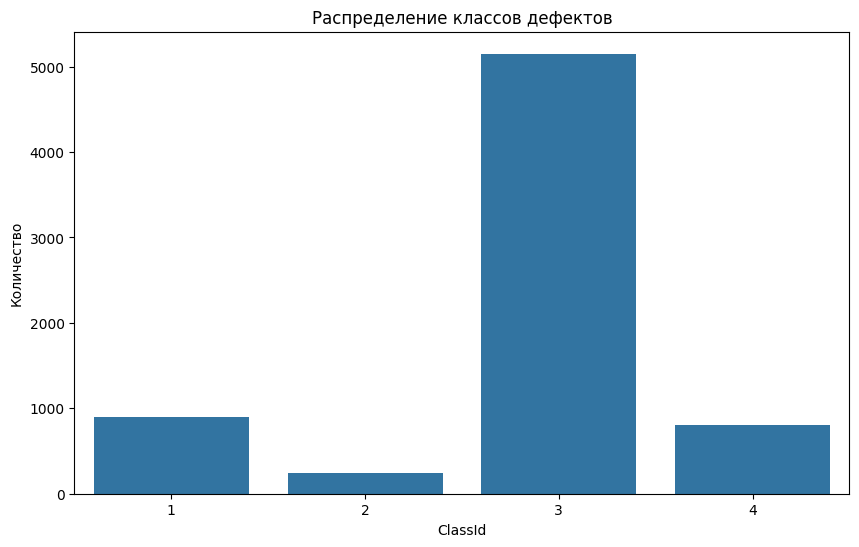

In [7]:
# Визуализация распределения классов дефектов
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title('Распределение классов дефектов')
plt.xlabel('ClassId')
plt.ylabel('Количество')
plt.show()

In [8]:
from tqdm import tqdm
import cv2

# Предполагаем, что data - это DataFrame с колонками 'ImageId', 'ClassId', 'EncodedPixels'

l1 = []
l2 = []
for img, ClassId, EncodedPixels in tqdm(data.values):
    img_path = 'severstal-steel-defect-detection\\train_images\\{}'.format(img)
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if image is not None:
        image = cv2.resize(image, (120, 120))
        l1.append(image)
        l2.append(ClassId)
    else:
        print(f"Warning: Could not read image {img_path}. It's being skipped.")

100%|██████████| 7095/7095 [00:32<00:00, 217.71it/s]


In [9]:
# Нормализация изображений
X = np.array(l1) / 255.0
encoder = LabelEncoder()
y = encoder.fit_transform(l2)
y = to_categorical(y)

In [10]:
# Борьба с дисбалансом классов
reshaped_X = X.reshape(X.shape[0], -1)
oversample = RandomOverSampler(sampling_strategy='not majority')
X, y = oversample.fit_resample(reshaped_X, y)
X = X.reshape(-1, 120, 120, 3)

In [11]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)

In [12]:
# Создание и обучение модели
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout

# Теперь вы можете создать модель, используя Sequential
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(120, 120, 3), activation="relu"))
model.add(BatchNormalization())  # Добавлено для нормализации входов в слой
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(BatchNormalization())  # Добавлено для нормализации входов в слой
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(BatchNormalization())  # Добавлено для нормализации входов в слой
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))  # Увеличено значение для усиления регуляризации
model.add(Dense(4, activation="softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=["accuracy"])

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks для ранней остановки и сохранения лучшей модели
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

In [14]:
from sklearn.model_selection import train_test_split

# Обучение модели
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=64,
                    verbose=1, callbacks=callbacks)

Epoch 1/50


258/258 [==============================] - ETA: 0s - loss: 1.6210 - accuracy: 0.6368
Epoch 1: val_loss improved from inf to 6.28979, saving model to best_model.h5


c:\Users\KIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


258/258 [==============================] - 123s 468ms/step - loss: 1.6210 - accuracy: 0.6368 - val_loss: 6.2898 - val_accuracy: 0.2500
Epoch 2/50
258/258 [==============================] - ETA: 0s - loss: 0.7228 - accuracy: 0.7208
Epoch 2: val_loss improved from 6.28979 to 1.90660, saving model to best_model.h5
258/258 [==============================] - 107s 416ms/step - loss: 0.7228 - accuracy: 0.7208 - val_loss: 1.9066 - val_accuracy: 0.3214
Epoch 3/50
258/258 [==============================] - ETA: 0s - loss: 0.5966 - accuracy: 0.7658
Epoch 3: val_loss improved from 1.90660 to 0.54682, saving model to best_model.h5
258/258 [==============================] - 113s 437ms/step - loss: 0.5966 - accuracy: 0.7658 - val_loss: 0.5468 - val_accuracy: 0.7733
Epoch 4/50
258/258 [==============================] - ETA: 0s - loss: 0.5309 - accuracy: 0.7925
Epoch 4: val_loss did not improve from 0.54682
258/258 [==============================] - 112s 435ms/step - loss: 0.5309 - accuracy: 0.7925 - v

<Axes: title={'center': 'Accuracy'}>

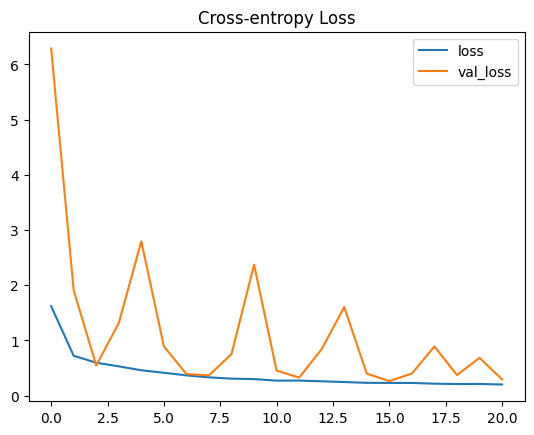

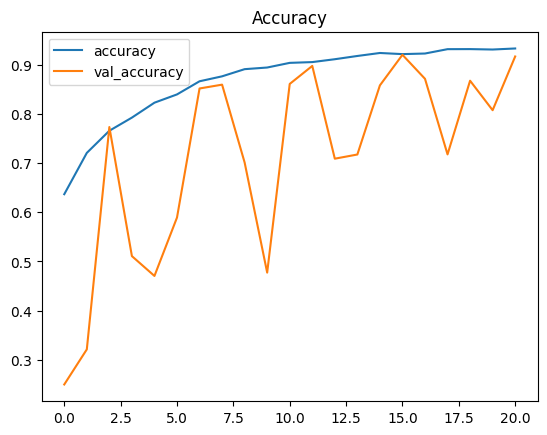

In [15]:
# Визуализация результатов обучения
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title='Cross-entropy Loss')
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title='Accuracy')

In [17]:
from tensorflow.keras.models import load_model

# Загрузка лучшей модели
model = load_model('best_model.h5')

# Оценка модели на тестовых данных
result = model.evaluate(X_test, y_test)
print(f"[+] Accuracy: {result[1]*100:.2f}%")

129/129 [==============================] - 9s 64ms/step - loss: 0.2645 - accuracy: 0.9201
[+] Accuracy: 92.01%


In [18]:
# Суммаризация модели
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 118, 118, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 59, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 57, 57, 64)        256       
 chNormalization)                                                
                                                        

Аргументация изменений:

* Batch Normalization: Добавление слоев Batch Normalization после каждого сверточного слоя помогает улучшить стабильность и скорость обучения, нормализуя входы каждого слоя.

* Увеличение Dropout: Увеличение значения Dropout до 0.5 усиливает регуляризацию, что может быть полезно для предотвращения переобучения в более сложной модели.

* Callbacks: Использование EarlyStopping позволяет остановить обучение, если валидационная потеря не улучшается в течение нескольких эпох, что экономит время и ресурсы. ModelCheckpoint сохраняет лучшую модель во время обучения, что позволяет использовать наилучшую версию модели для оценки и предсказаний.

* Изменение размера batch и количества эпох: Уменьшение размера batch до 64 может улучшить обобщающую способность модели и позволить более детально обновлять веса. Увеличение количества эпох до 50 дает модели больше времени для обучения, при этом EarlyStopping предотвратит переобучение.

* Загрузка лучшей модели для оценки: После обучения загружается лучшая модель для оценки на тестовых данных.

Эти изменения направлены на улучшение качества модели и её способности учиться на новых данных.

Данные по Северстали взяты из: https://drive.google.com/drive/folders/1ZT1N5Mh89L1YuDOVgAxKhKEq5YEZ0E14?usp=sharing